# Transfer Learning Image Classification
## Classifying NBA Teams from NBA Player Photos

The following notebook trains a multi-class image classification model using limited data with transfer learning.

Specifically, we will be training an image classifier to classify NBA player profile pictures to their corresponding NBA team.

In [1]:
import os
from IPython.display import Image

In [2]:
data_dir = 'nba_player_photos'

## Data Preparation

### Scrape the data

NBA Player photos will be scraped from www.nba.com.
* There are **30** classes (NBA teams)
* There are **15-18** items per class (NBA players)
* Photos are **1040x760** pixels

**Note:** Depending on when the data is scraped, players may have since been traded and are on new teams from their original photos, thus introducing dirtiness to the data. For clean data corresponding to the beginning of the 2022-23 season, [download]() the zip file from GitHub.



In [3]:
import requests

from bs4 import BeautifulSoup
from pathlib import Path
from tqdm.notebook import tqdm
from typing import List

In [4]:
def get_teams_info() -> List[List[str]]:
  TEAMS_URL = 'https://www.nba.com/teams'
  TEAMS_LINK_CLASS = 'TeamFigure_tfLinks__gwWFj'
  html = requests.get(TEAMS_URL).content
  soup = BeautifulSoup(html, 'html.parser')
  teams = []
  for team_links in soup.find_all('div', {'class': TEAMS_LINK_CLASS}):
    profile_link = next(team_links.children)
    link_parts = profile_link['href'].split('/')
    team_name, team_id = link_parts[3], link_parts[2]
    teams.append([team_name, team_id])
  return teams

In [5]:
teams_info = get_teams_info()
pbar = tqdm(teams_info)
for team_name, team_id in pbar:
  pbar.set_description(f'Downloading {team_name} photos')
  Path(os.path.join(data_dir, team_name)).mkdir(parents=True, exist_ok=True)
  team_url = f'https://www.nba.com/team/{team_id}/{team_name}'
  roster_table = None
  while roster_table == None: # loop in case unsuccessful URL get
    html = requests.get(team_url).content
    soup = BeautifulSoup(html, 'html.parser')
    roster_table = soup.find('table')
  roster_rows = roster_table.find_all('tr')
  for player_row in roster_rows[1:]: # skip header row
    link_parts = player_row.find('a')['href'].split('/')
    player_name, player_id = link_parts[3], link_parts[2]
    player_pic_url = \
      f'https://cdn.nba.com/headshots/nba/latest/1040x760/{player_id}.png'
    img_data = requests.get(player_pic_url).content
    img_path = os.path.join(data_dir, team_name, f'{player_name}.png')
    with open(img_path, 'wb') as file:
      file.write(img_data)
  if pbar.n + 1 == len(teams_info):
    pbar.set_description(f'Downloaded all photos')

  0%|          | 0/30 [00:00<?, ?it/s]

#### Sample data point

observation: jordan-hall


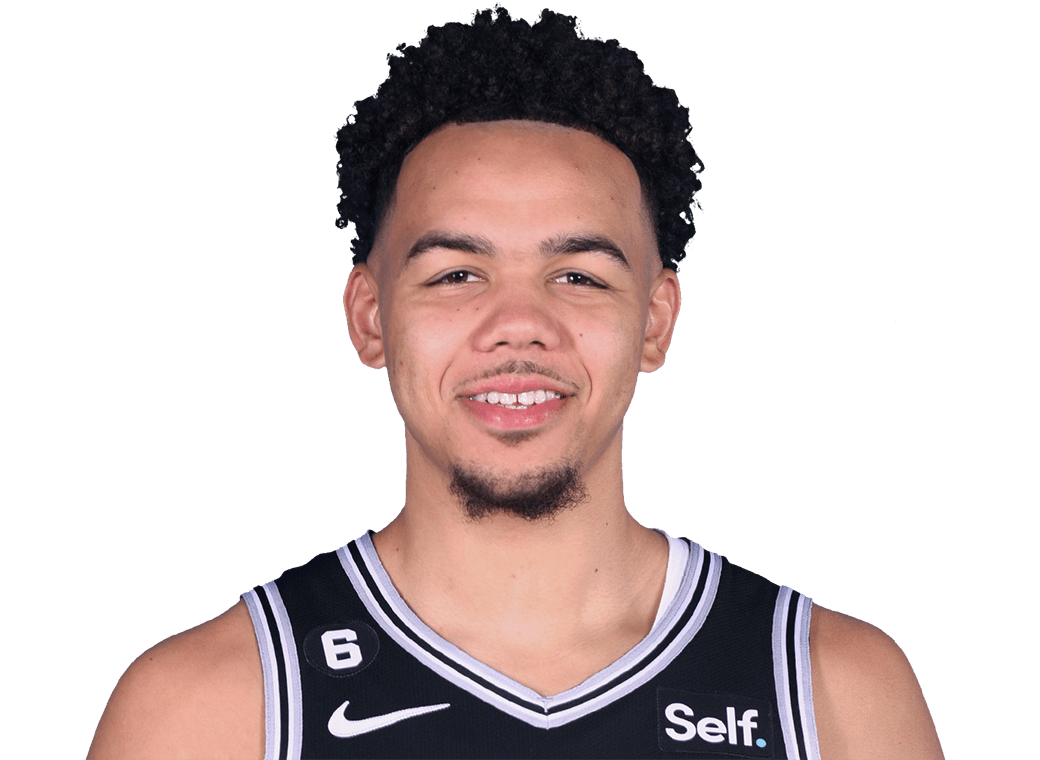

class: spurs


In [6]:
print(f'observation: {player_name}')
display(Image(f'{data_dir}/{team_name}/{player_name}.png'))
print(f'class: {team_name}')

### Create train/test data split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
seed = None
test_size = 0.15

In [ ]:
train_paths = []
test_paths = []
for root, _, files in os.walk(data_dir):
  if len(files) == 0:
    continue
  train_files, test_files = train_test_split(
      files, test_size=test_size, random_state=seed)
  train_paths += list(map(lambda file: os.path.join(root, file), train_files))
  test_paths += list(map(lambda file: os.path.join(root, file), test_files))
print(f'Number of train images: {len(train_paths)}')
print(f'Number of test images: {len(test_paths)}')

### Transform data into tensors

## Model Building